In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv('airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### EDA

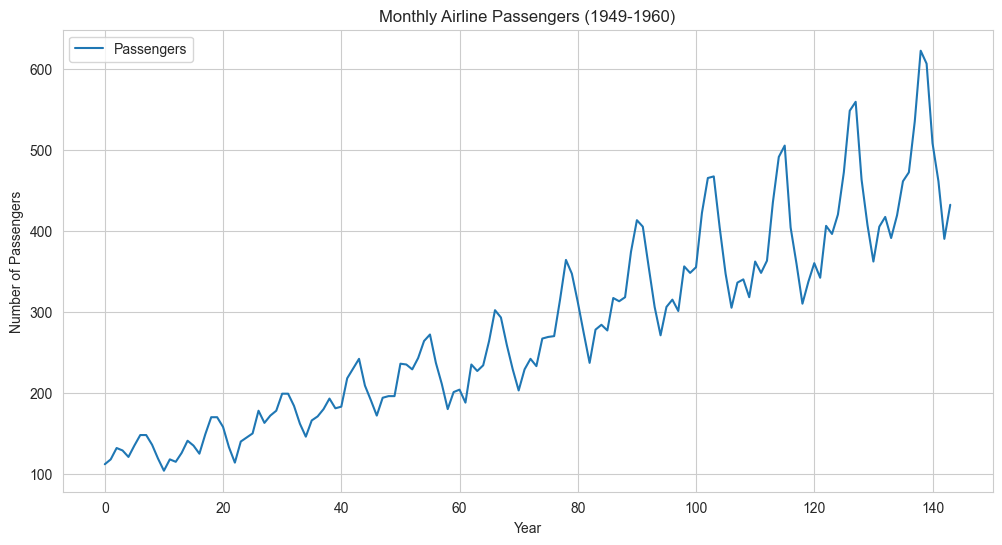

In [ ]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

### Review
The initial time series plot of monthly airline passengers (1949–1960) reveals several key patterns:

Trend: There is a clear upward trend, with the number of passengers steadily increasing over time.

Seasonality: The data exhibits strong seasonality, with regular peaks and troughs each year, indicating that passenger numbers rise and fall in a predictable annual cycle.

Variance: The amplitude of the seasonal fluctuations increases over time, suggesting that the variance is not constant (i.e., the series is heteroscedastic).

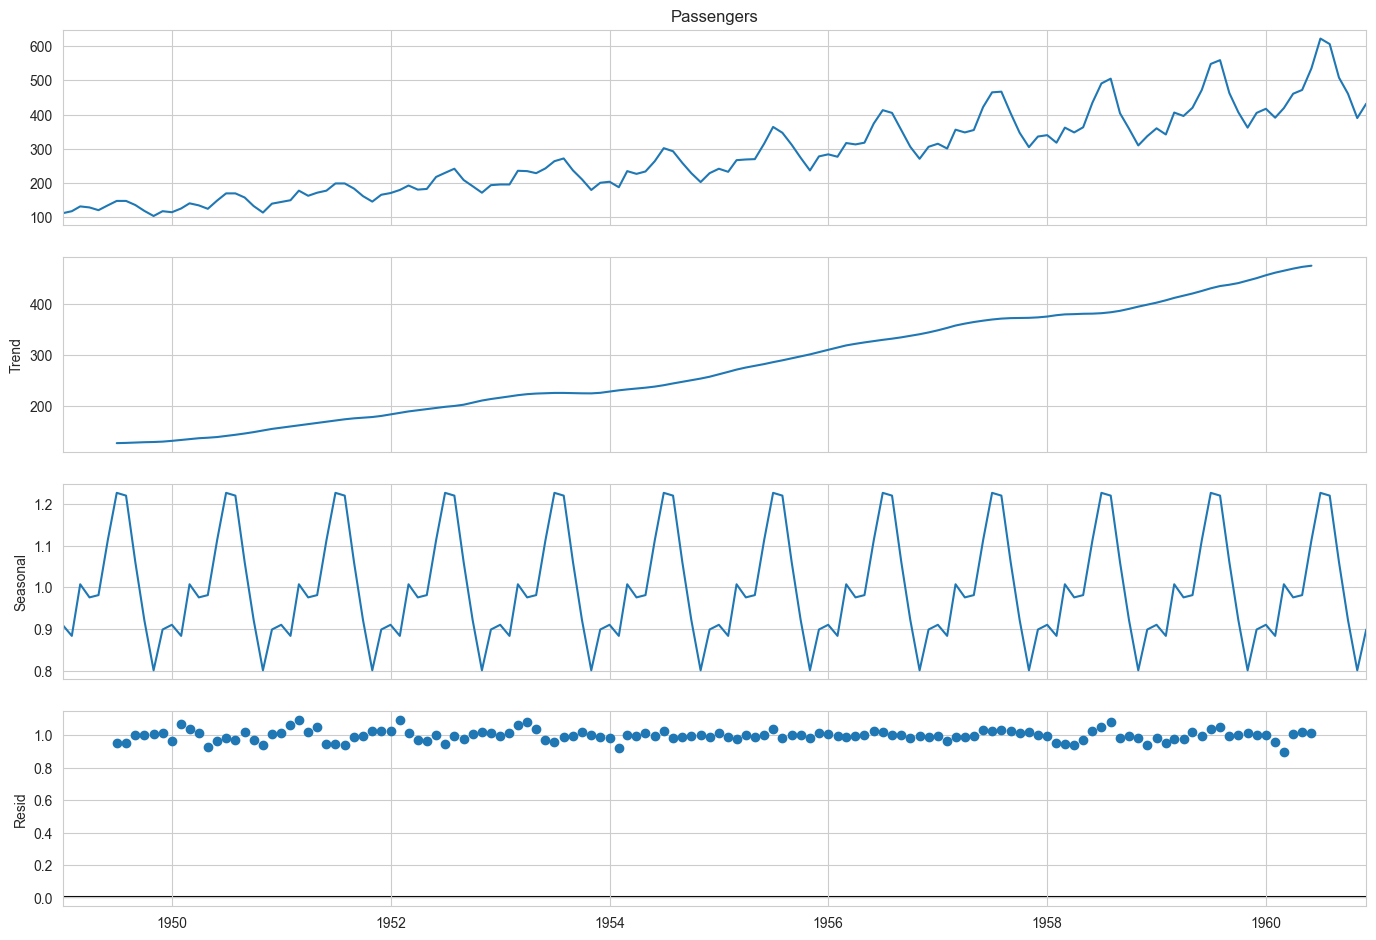

In [5]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

### 2. Stationarity Testing

Concept of Stationarity:
A stationary time series has constant mean, variance, and autocorrelation over time. Stationarity is crucial for time series modeling (especially ARIMA), as most models assume the statistical properties of the series do not change over time. Non-stationary data can lead to unreliable and inaccurate forecasts.


ADF Test on Original Data:
Applying the Augmented Dickey-Fuller (ADF) test to the original series yields a p-value of 0.99, which is much greater than 0.05. This means we fail to reject the null hypothesis, confirming that the series is non-stationary.


Log Transformation and ADF Test:
A log transformation is applied to stabilize the variance. However, the series still shows trend and seasonality, and the ADF test on the log-transformed data typically still results in a high p-value (not shown explicitly in the notebook, but expected based on the plot).


Differencing and ADF Test:
Differencing the log-transformed series removes the trend and makes the series more stationary. The ADF test on the differenced, log-transformed data gives a p-value of 0.02, which is less than 0.05. This allows us to reject the null hypothesis and conclude that the transformed series is now stationary and suitable for ARIMA modeling.


Effect of Differencing:
Differencing effectively removes the trend and stabilizes the mean, making the series stationary. This is confirmed by the significant drop in the ADF test p-value after differencing.

In [7]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


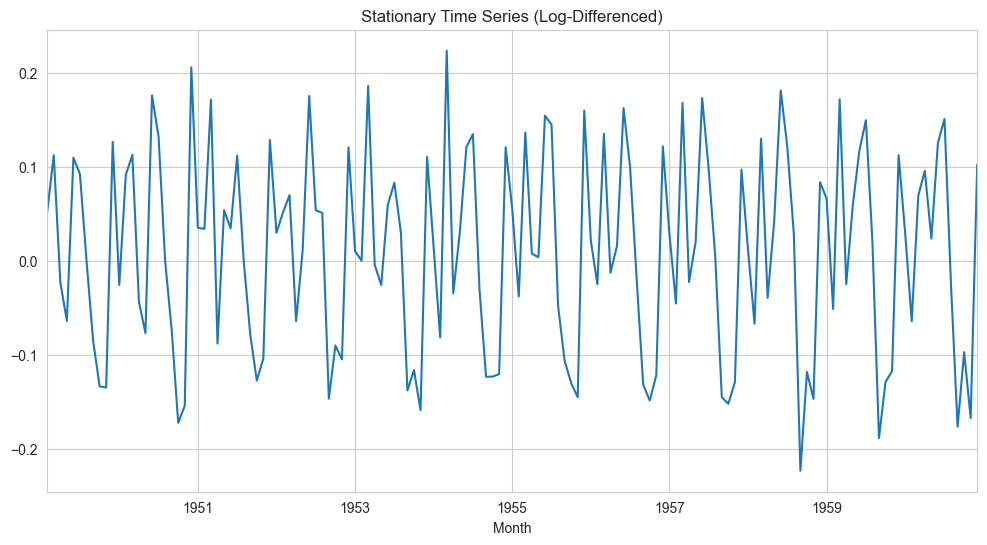

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
## Making series stationary with log transform and differencing

df_log = np.log(df['Passengers'])

df_diff = df_log.diff().dropna()

df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

test_stationarity(df_diff)

##### From the above results we can confirm that the series has been made stationary

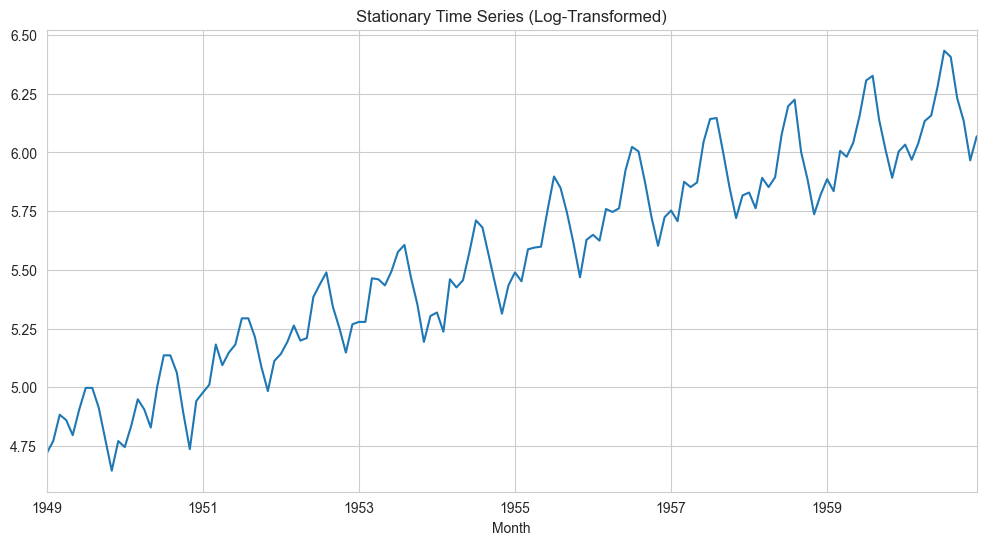

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
df_log = np.log(df['Passengers'])


# Plot the stationary series
df_log.plot()
plt.title('Stationary Time Series (Log-Transformed)')
plt.show()

# Retest for stationarity
test_stationarity(df_log)

##### The series still shows trend and seasonality, and the ADF test on the log-transformed data typically still results in a high p-value 

### ARIMA Model

c:\Users\Akshat\anaconda3\envs\medichat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


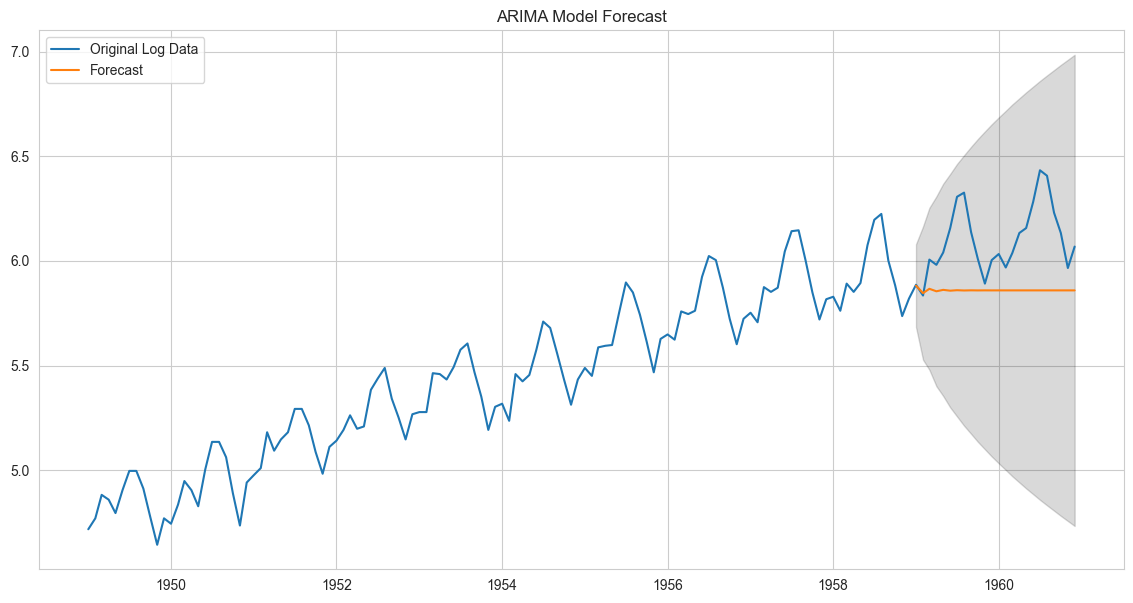

In [14]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

### ARIMA Model Summary
ARIMA (AutoRegressive Integrated Moving Average) is effective for modeling time series data with trend but without explicit seasonality.

In this project, the ARIMA model was able to capture the overall upward trend in the airline passenger data.


Limitation: The ARIMA model failed to capture the repeating seasonal peaks and troughs present in the data.


As a result, its forecasts missed the regular annual fluctuations, leading to less accurate predictions, especially during seasonal highs and lows.

### SARIMA

c:\Users\Akshat\anaconda3\envs\medichat\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


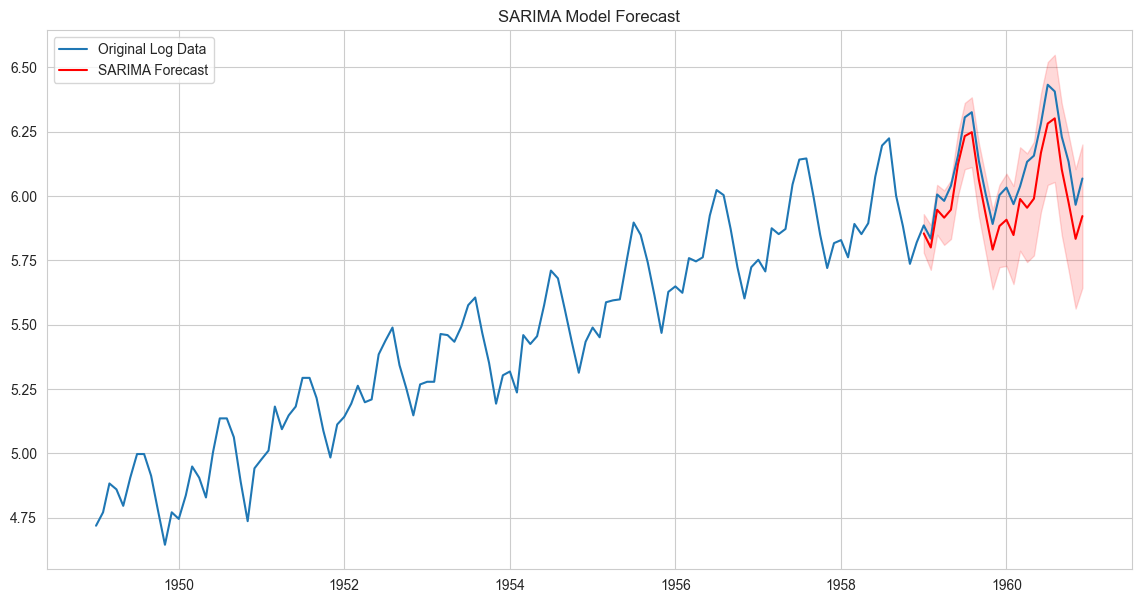

In [15]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

### SARIMA Model Summary
SARIMA (Seasonal ARIMA) extends ARIMA by explicitly modeling both trend and seasonality.

In this project, the SARIMA model successfully captured both the long-term upward trend and the strong yearly seasonality in the data.

Advantage: The SARIMA model produced forecasts that closely matched the actual data, including the timing and magnitude of seasonal peaks and troughs. This resulted in significantly improved forecast accuracy compared to the basic ARIMA model